In [1]:
# Multi-Layer Perceptron

In [2]:
import numpy as np
import tensorflow as tf

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [3]:
tf.set_random_seed(123)

In [4]:
from sklearn.utils import shuffle

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [6]:
class MLP(object):
    def __init__(self, graph, dim_input, dim_hiddens, dim_output):
        self.graph = graph
        self.dim_input = dim_input
        self.dim_hiddens = dim_hiddens
        self.dim_output = dim_output
        
        self.weights = []
        self.biases = []
        
        self._x = None
        self._t = None
        self._y = None

        self._loss = None
        self._train_step = None
        self._accuracy = None
        
        self._sess = None
        
        self._history = {
            'accuracy': [],
            'loss': []
        }
    
    def weight_variable(self, shape):
        initial = tf.truncated_normal(shape)
        return tf.Variable(initial, name='W')
    
    def bias_variable(self, shape):
        initial = tf.zeros(shape)
        return tf.Variable(initial, name='b')
    
    def inference(self, x):
        for i, dim_hidden in enumerate(self.dim_hiddens):
            with tf.name_scope('Hidden_Layer_{0}'.format(i+1)):
                if i == 0:
                    input = x
                    dim_input = self.dim_input
                else:
                    input = output
                    dim_input = self.dim_hiddens[i-1]

                self.weights.append(self.weight_variable([dim_input, dim_hidden]))
                self.biases.append(self.bias_variable([dim_hidden]))

                output = tf.nn.sigmoid(tf.matmul(input, self.weights[-1]) + self.biases[-1])

        with tf.name_scope('Output_Layer'):
            self.weights.append(self.weight_variable([self.dim_hiddens[-1], self.dim_output]))
            self.biases.append(self.bias_variable([self.dim_output]))

            y = tf.nn.sigmoid(tf.matmul(output, self.weights[-1]) + self.biases[-1])

        return y

    def loss(self, y, t):
        with tf.name_scope('Loss'):
            cross_entropy = - tf.reduce_sum(t * tf.log(y) + (1 - t) * tf.log(1 - y))
        
            return cross_entropy
    
    def training(self, loss, lr=0.1):
        with tf.name_scope('Train'):
            optimizer = tf.train.GradientDescentOptimizer(lr)
            train_step = optimizer.minimize(loss)
            return train_step
    
    def accuracy(self, y, t):
        with tf.name_scope('Accuracy'):
            correct_prediction = tf.equal(tf.to_float(tf.greater(y, 0.5)), t)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            return accuracy
 
    def compile(self, lr=0.1):
        with self.graph.as_default():
            x = tf.placeholder(tf.float32, shape=[None, self.dim_input], name='x')
            t = tf.placeholder(tf.float32, shape=[None, self.dim_output], name='t')

            y = self.inference(x)

            loss = self.loss(y, t)
            train_step = self.training(loss, lr)
            accuracy = self.accuracy(y, t)
        
        self._x = x
        self._t = t
        self._y = y
        
        self._loss = loss
        self._train_step = train_step
        self._accuracy = accuracy

    def fit(self, X_train, Y_train, epochs=100, batch_size=100, verbose=1):
        N_train = len(X_train)
        n_batches = N_train // batch_size
        
        with self.graph.as_default():
            init = tf.global_variables_initializer()
            sess = tf.Session()
            sess.run(init)

            self._sess = sess

            for epoch in range(epochs):
                X_, Y_ = shuffle(X_train, Y_train)

                for i in range(n_batches):
                    start = i * batch_size
                    end = start + batch_size

                    sess.run(
                        self._train_step,
                        feed_dict={
                            self._x: X_[start:end],
                            self._t: Y_[start:end]
                        })

                loss_ = self._loss.eval(
                            session=sess,
                            feed_dict={
                                self._x: X_train,
                                self._t: Y_train
                            })

                accuracy_ = self._accuracy.eval(
                                session=sess,
                                feed_dict={
                                    self._x: X_train,
                                    self._t: Y_train
                                })

                self._history['loss'].append(loss_)
                self._history['accuracy'].append(accuracy_)

                if verbose:
                    print("epoch: {0} / loss: {1} / accuracy: {2}".format(epoch, loss_, accuracy_))

            return self._history
        
    def evaluate(self, X_test, Y_test):
        with self.graph.as_default():
            return self.accuracy.eval(
                        session=self._sess,
                        feed_dict={
                            self._x: X_test,
                            self._t: Y_test
                        })
    
    def output(self, X_test):
        with self.graph.as_default():
            return self._y.eval(session=self._sess,
                                feed_dict={
                                    self._x: X_test
                                })
    
    def show_graph_model(self):
        with self.graph.as_default():
            show_graph(tf.Session().graph_def)
            
    def show_graph_loss(self):
        fig = plt.figure(figsize=(16, 4))
        ax = fig.add_subplot(111)
        ax.plot(self._history['loss'])
        
        ax.set_title('Loss')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')

        plt.show() 

    def show_graph_accuracy(self):
        fig = plt.figure(figsize=(16, 4))
        ax = fig.add_subplot(111)
        ax.plot(self._history['accuracy'])
        
        ax.set_title('Accuracy')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Accuracy')
        
        plt.show() 

In [7]:
# Preparing data

In [8]:
X = np.array([
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]
])

In [9]:
Y = np.array([0, 1, 1, 0])[:, np.newaxis]

In [10]:
# Building a model

In [11]:
model = MLP(tf.Graph(),
            dim_input=2,
            dim_hiddens=[2],
            dim_output=1)

In [12]:
model.compile()

In [13]:
model.show_graph_model()

In [14]:
history = model.fit(X,
                    Y,
                    epochs=4000,
                    batch_size=4)

epoch: 0 / loss: 2.9576663970947266 / accuracy: 0.5
epoch: 1 / loss: 2.9125499725341797 / accuracy: 0.5
epoch: 2 / loss: 2.8783907890319824 / accuracy: 0.5
epoch: 3 / loss: 2.8524868488311768 / accuracy: 0.5
epoch: 4 / loss: 2.8327736854553223 / accuracy: 0.5
epoch: 5 / loss: 2.8176870346069336 / accuracy: 0.25
epoch: 6 / loss: 2.8060522079467773 / accuracy: 0.5
epoch: 7 / loss: 2.7969884872436523 / accuracy: 0.5
epoch: 8 / loss: 2.789839267730713 / accuracy: 0.5
epoch: 9 / loss: 2.7841148376464844 / accuracy: 0.5
epoch: 10 / loss: 2.779451847076416 / accuracy: 0.5
epoch: 11 / loss: 2.775578498840332 / accuracy: 0.5
epoch: 12 / loss: 2.772294282913208 / accuracy: 0.5
epoch: 13 / loss: 2.7694485187530518 / accuracy: 0.5
epoch: 14 / loss: 2.766930103302002 / accuracy: 0.5
epoch: 15 / loss: 2.7646560668945312 / accuracy: 0.5
epoch: 16 / loss: 2.7625646591186523 / accuracy: 0.5
epoch: 17 / loss: 2.7606101036071777 / accuracy: 0.5
epoch: 18 / loss: 2.7587571144104004 / accuracy: 0.5
epoch: 

epoch: 194 / loss: 2.448808193206787 / accuracy: 0.75
epoch: 195 / loss: 2.4465904235839844 / accuracy: 0.75
epoch: 196 / loss: 2.444368362426758 / accuracy: 0.75
epoch: 197 / loss: 2.4421417713165283 / accuracy: 0.75
epoch: 198 / loss: 2.439910888671875 / accuracy: 0.75
epoch: 199 / loss: 2.437676191329956 / accuracy: 0.75
epoch: 200 / loss: 2.4354376792907715 / accuracy: 0.75
epoch: 201 / loss: 2.433195114135742 / accuracy: 0.75
epoch: 202 / loss: 2.4309489727020264 / accuracy: 0.75
epoch: 203 / loss: 2.428699016571045 / accuracy: 0.75
epoch: 204 / loss: 2.426445484161377 / accuracy: 0.75
epoch: 205 / loss: 2.4241890907287598 / accuracy: 0.75
epoch: 206 / loss: 2.421928644180298 / accuracy: 0.75
epoch: 207 / loss: 2.4196653366088867 / accuracy: 0.75
epoch: 208 / loss: 2.4173989295959473 / accuracy: 0.75
epoch: 209 / loss: 2.4151296615600586 / accuracy: 0.75
epoch: 210 / loss: 2.4128572940826416 / accuracy: 0.75
epoch: 211 / loss: 2.4105820655822754 / accuracy: 0.75
epoch: 212 / loss:

epoch: 368 / loss: 2.0655064582824707 / accuracy: 0.75
epoch: 369 / loss: 2.0634818077087402 / accuracy: 0.75
epoch: 370 / loss: 2.0614585876464844 / accuracy: 0.75
epoch: 371 / loss: 2.059436321258545 / accuracy: 0.75
epoch: 372 / loss: 2.057415008544922 / accuracy: 0.75
epoch: 373 / loss: 2.0553951263427734 / accuracy: 0.75
epoch: 374 / loss: 2.0533761978149414 / accuracy: 0.75
epoch: 375 / loss: 2.051358222961426 / accuracy: 0.75
epoch: 376 / loss: 2.0493412017822266 / accuracy: 0.75
epoch: 377 / loss: 2.0473246574401855 / accuracy: 0.75
epoch: 378 / loss: 2.045309066772461 / accuracy: 0.75
epoch: 379 / loss: 2.0432944297790527 / accuracy: 0.75
epoch: 380 / loss: 2.0412802696228027 / accuracy: 0.75
epoch: 381 / loss: 2.039266586303711 / accuracy: 0.75
epoch: 382 / loss: 2.0372538566589355 / accuracy: 0.75
epoch: 383 / loss: 2.03524112701416 / accuracy: 0.75
epoch: 384 / loss: 2.033229351043701 / accuracy: 0.75
epoch: 385 / loss: 2.031217575073242 / accuracy: 0.75
epoch: 386 / loss: 

epoch: 530 / loss: 1.677667260169983 / accuracy: 0.75
epoch: 531 / loss: 1.6741156578063965 / accuracy: 0.75
epoch: 532 / loss: 1.6705397367477417 / accuracy: 0.75
epoch: 533 / loss: 1.6669392585754395 / accuracy: 0.75
epoch: 534 / loss: 1.6633145809173584 / accuracy: 0.75
epoch: 535 / loss: 1.6596657037734985 / accuracy: 0.75
epoch: 536 / loss: 1.6559927463531494 / accuracy: 0.75
epoch: 537 / loss: 1.6522951126098633 / accuracy: 0.75
epoch: 538 / loss: 1.6485737562179565 / accuracy: 0.75
epoch: 539 / loss: 1.64482843875885 / accuracy: 0.75
epoch: 540 / loss: 1.6410590410232544 / accuracy: 0.75
epoch: 541 / loss: 1.637265920639038 / accuracy: 0.75
epoch: 542 / loss: 1.6334491968154907 / accuracy: 0.75
epoch: 543 / loss: 1.6296088695526123 / accuracy: 0.75
epoch: 544 / loss: 1.6257450580596924 / accuracy: 0.75
epoch: 545 / loss: 1.6218581199645996 / accuracy: 0.75
epoch: 546 / loss: 1.617948055267334 / accuracy: 0.75
epoch: 547 / loss: 1.6140148639678955 / accuracy: 0.75
epoch: 548 / lo

epoch: 710 / loss: 0.8921613693237305 / accuracy: 1.0
epoch: 711 / loss: 0.8883822560310364 / accuracy: 1.0
epoch: 712 / loss: 0.8846191167831421 / accuracy: 1.0
epoch: 713 / loss: 0.8808722496032715 / accuracy: 1.0
epoch: 714 / loss: 0.8771417140960693 / accuracy: 1.0
epoch: 715 / loss: 0.873427152633667 / accuracy: 1.0
epoch: 716 / loss: 0.8697288632392883 / accuracy: 1.0
epoch: 717 / loss: 0.8660464286804199 / accuracy: 1.0
epoch: 718 / loss: 0.8623805642127991 / accuracy: 1.0
epoch: 719 / loss: 0.8587312698364258 / accuracy: 1.0
epoch: 720 / loss: 0.855097770690918 / accuracy: 1.0
epoch: 721 / loss: 0.8514807224273682 / accuracy: 1.0
epoch: 722 / loss: 0.8478801250457764 / accuracy: 1.0
epoch: 723 / loss: 0.8442957401275635 / accuracy: 1.0
epoch: 724 / loss: 0.8407281637191772 / accuracy: 1.0
epoch: 725 / loss: 0.8371764421463013 / accuracy: 1.0
epoch: 726 / loss: 0.8336412310600281 / accuracy: 1.0
epoch: 727 / loss: 0.8301225900650024 / accuracy: 1.0
epoch: 728 / loss: 0.826620101

epoch: 895 / loss: 0.4386346936225891 / accuracy: 1.0
epoch: 896 / loss: 0.4372135400772095 / accuracy: 1.0
epoch: 897 / loss: 0.435799777507782 / accuracy: 1.0
epoch: 898 / loss: 0.4343934953212738 / accuracy: 1.0
epoch: 899 / loss: 0.4329947233200073 / accuracy: 1.0
epoch: 900 / loss: 0.43160316348075867 / accuracy: 1.0
epoch: 901 / loss: 0.43021902441978455 / accuracy: 1.0
epoch: 902 / loss: 0.42884206771850586 / accuracy: 1.0
epoch: 903 / loss: 0.4274722635746002 / accuracy: 1.0
epoch: 904 / loss: 0.42610964179039 / accuracy: 1.0
epoch: 905 / loss: 0.4247540831565857 / accuracy: 1.0
epoch: 906 / loss: 0.42340582609176636 / accuracy: 1.0
epoch: 907 / loss: 0.42206448316574097 / accuracy: 1.0
epoch: 908 / loss: 0.4207301139831543 / accuracy: 1.0
epoch: 909 / loss: 0.4194026589393616 / accuracy: 1.0
epoch: 910 / loss: 0.4180818796157837 / accuracy: 1.0
epoch: 911 / loss: 0.41676831245422363 / accuracy: 1.0
epoch: 912 / loss: 0.41546130180358887 / accuracy: 1.0
epoch: 913 / loss: 0.414

epoch: 1050 / loss: 0.2846447229385376 / accuracy: 1.0
epoch: 1051 / loss: 0.28396594524383545 / accuracy: 1.0
epoch: 1052 / loss: 0.28328990936279297 / accuracy: 1.0
epoch: 1053 / loss: 0.2826169729232788 / accuracy: 1.0
epoch: 1054 / loss: 0.28194674849510193 / accuracy: 1.0
epoch: 1055 / loss: 0.28127944469451904 / accuracy: 1.0
epoch: 1056 / loss: 0.2806147634983063 / accuracy: 1.0
epoch: 1057 / loss: 0.2799530625343323 / accuracy: 1.0
epoch: 1058 / loss: 0.2792941629886627 / accuracy: 1.0
epoch: 1059 / loss: 0.2786378562450409 / accuracy: 1.0
epoch: 1060 / loss: 0.27798449993133545 / accuracy: 1.0
epoch: 1061 / loss: 0.27733370661735535 / accuracy: 1.0
epoch: 1062 / loss: 0.27668559551239014 / accuracy: 1.0
epoch: 1063 / loss: 0.2760401964187622 / accuracy: 1.0
epoch: 1064 / loss: 0.275397390127182 / accuracy: 1.0
epoch: 1065 / loss: 0.2747575342655182 / accuracy: 1.0
epoch: 1066 / loss: 0.2741200923919678 / accuracy: 1.0
epoch: 1067 / loss: 0.27348557114601135 / accuracy: 1.0
epo

epoch: 1209 / loss: 0.20428620278835297 / accuracy: 1.0
epoch: 1210 / loss: 0.20391389727592468 / accuracy: 1.0
epoch: 1211 / loss: 0.20354269444942474 / accuracy: 1.0
epoch: 1212 / loss: 0.20317280292510986 / accuracy: 1.0
epoch: 1213 / loss: 0.20280414819717407 / accuracy: 1.0
epoch: 1214 / loss: 0.20243671536445618 / accuracy: 1.0
epoch: 1215 / loss: 0.20207053422927856 / accuracy: 1.0
epoch: 1216 / loss: 0.20170553028583527 / accuracy: 1.0
epoch: 1217 / loss: 0.20134176313877106 / accuracy: 1.0
epoch: 1218 / loss: 0.20097924768924713 / accuracy: 1.0
epoch: 1219 / loss: 0.20061790943145752 / accuracy: 1.0
epoch: 1220 / loss: 0.20025759935379028 / accuracy: 1.0
epoch: 1221 / loss: 0.19989866018295288 / accuracy: 1.0
epoch: 1222 / loss: 0.19954076409339905 / accuracy: 1.0
epoch: 1223 / loss: 0.19918423891067505 / accuracy: 1.0
epoch: 1224 / loss: 0.19882889091968536 / accuracy: 1.0
epoch: 1225 / loss: 0.1984744518995285 / accuracy: 1.0
epoch: 1226 / loss: 0.19812151789665222 / accurac

epoch: 1386 / loss: 0.1535700261592865 / accuracy: 1.0
epoch: 1387 / loss: 0.1533510833978653 / accuracy: 1.0
epoch: 1388 / loss: 0.15313252806663513 / accuracy: 1.0
epoch: 1389 / loss: 0.15291467308998108 / accuracy: 1.0
epoch: 1390 / loss: 0.1526973843574524 / accuracy: 1.0
epoch: 1391 / loss: 0.15248066186904907 / accuracy: 1.0
epoch: 1392 / loss: 0.15226447582244873 / accuracy: 1.0
epoch: 1393 / loss: 0.1520489603281021 / accuracy: 1.0
epoch: 1394 / loss: 0.15183402597904205 / accuracy: 1.0
epoch: 1395 / loss: 0.15161967277526855 / accuracy: 1.0
epoch: 1396 / loss: 0.15140581130981445 / accuracy: 1.0
epoch: 1397 / loss: 0.15119260549545288 / accuracy: 1.0
epoch: 1398 / loss: 0.15097972750663757 / accuracy: 1.0
epoch: 1399 / loss: 0.15076777338981628 / accuracy: 1.0
epoch: 1400 / loss: 0.15055616199970245 / accuracy: 1.0
epoch: 1401 / loss: 0.150345116853714 / accuracy: 1.0
epoch: 1402 / loss: 0.1501346379518509 / accuracy: 1.0
epoch: 1403 / loss: 0.14992479979991913 / accuracy: 1.0

epoch: 1549 / loss: 0.1242760717868805 / accuracy: 1.0
epoch: 1550 / loss: 0.1241292953491211 / accuracy: 1.0
epoch: 1551 / loss: 0.12398270517587662 / accuracy: 1.0
epoch: 1552 / loss: 0.12383648753166199 / accuracy: 1.0
epoch: 1553 / loss: 0.1236906498670578 / accuracy: 1.0
epoch: 1554 / loss: 0.12354500591754913 / accuracy: 1.0
epoch: 1555 / loss: 0.12339979410171509 / accuracy: 1.0
epoch: 1556 / loss: 0.12325489521026611 / accuracy: 1.0
epoch: 1557 / loss: 0.12311030924320221 / accuracy: 1.0
epoch: 1558 / loss: 0.12296611070632935 / accuracy: 1.0
epoch: 1559 / loss: 0.12282209098339081 / accuracy: 1.0
epoch: 1560 / loss: 0.12267845124006271 / accuracy: 1.0
epoch: 1561 / loss: 0.12253519147634506 / accuracy: 1.0
epoch: 1562 / loss: 0.12239212542772293 / accuracy: 1.0
epoch: 1563 / loss: 0.12224942445755005 / accuracy: 1.0
epoch: 1564 / loss: 0.12210716307163239 / accuracy: 1.0
epoch: 1565 / loss: 0.12196516245603561 / accuracy: 1.0
epoch: 1566 / loss: 0.12182334065437317 / accuracy:

epoch: 1740 / loss: 0.10117892175912857 / accuracy: 1.0
epoch: 1741 / loss: 0.10107966512441635 / accuracy: 1.0
epoch: 1742 / loss: 0.10098066180944443 / accuracy: 1.0
epoch: 1743 / loss: 0.10088183730840683 / accuracy: 1.0
epoch: 1744 / loss: 0.1007830873131752 / accuracy: 1.0
epoch: 1745 / loss: 0.10068458318710327 / accuracy: 1.0
epoch: 1746 / loss: 0.10058631747961044 / accuracy: 1.0
epoch: 1747 / loss: 0.10048811882734299 / accuracy: 1.0
epoch: 1748 / loss: 0.10039018094539642 / accuracy: 1.0
epoch: 1749 / loss: 0.10029241442680359 / accuracy: 1.0
epoch: 1750 / loss: 0.10019484162330627 / accuracy: 1.0
epoch: 1751 / loss: 0.10009732842445374 / accuracy: 1.0
epoch: 1752 / loss: 0.1000003069639206 / accuracy: 1.0
epoch: 1753 / loss: 0.09990304708480835 / accuracy: 1.0
epoch: 1754 / loss: 0.09980621933937073 / accuracy: 1.0
epoch: 1755 / loss: 0.09970951080322266 / accuracy: 1.0
epoch: 1756 / loss: 0.09961311519145966 / accuracy: 1.0
epoch: 1757 / loss: 0.09951677918434143 / accuracy

epoch: 1893 / loss: 0.0878971666097641 / accuracy: 1.0
epoch: 1894 / loss: 0.08782142400741577 / accuracy: 1.0
epoch: 1895 / loss: 0.08774574100971222 / accuracy: 1.0
epoch: 1896 / loss: 0.08767016977071762 / accuracy: 1.0
epoch: 1897 / loss: 0.08759491890668869 / accuracy: 1.0
epoch: 1898 / loss: 0.08751960098743439 / accuracy: 1.0
epoch: 1899 / loss: 0.08744452893733978 / accuracy: 1.0
epoch: 1900 / loss: 0.08736951649188995 / accuracy: 1.0
epoch: 1901 / loss: 0.08729451894760132 / accuracy: 1.0
epoch: 1902 / loss: 0.08721975982189178 / accuracy: 1.0
epoch: 1903 / loss: 0.08714517951011658 / accuracy: 1.0
epoch: 1904 / loss: 0.08707067370414734 / accuracy: 1.0
epoch: 1905 / loss: 0.08699627965688705 / accuracy: 1.0
epoch: 1906 / loss: 0.08692200481891632 / accuracy: 1.0
epoch: 1907 / loss: 0.08684787154197693 / accuracy: 1.0
epoch: 1908 / loss: 0.08677385747432709 / accuracy: 1.0
epoch: 1909 / loss: 0.0866999626159668 / accuracy: 1.0
epoch: 1910 / loss: 0.0866260677576065 / accuracy:

epoch: 2066 / loss: 0.07643068581819534 / accuracy: 1.0
epoch: 2067 / loss: 0.07637288421392441 / accuracy: 1.0
epoch: 2068 / loss: 0.07631508260965347 / accuracy: 1.0
epoch: 2069 / loss: 0.07625740766525269 / accuracy: 1.0
epoch: 2070 / loss: 0.0761997252702713 / accuracy: 1.0
epoch: 2071 / loss: 0.07614229619503021 / accuracy: 1.0
epoch: 2072 / loss: 0.07608486711978912 / accuracy: 1.0
epoch: 2073 / loss: 0.07602749019861221 / accuracy: 1.0
epoch: 2074 / loss: 0.0759701281785965 / accuracy: 1.0
epoch: 2075 / loss: 0.07591299712657928 / accuracy: 1.0
epoch: 2076 / loss: 0.07585587352514267 / accuracy: 1.0
epoch: 2077 / loss: 0.0757988691329956 / accuracy: 1.0
epoch: 2078 / loss: 0.07574187219142914 / accuracy: 1.0
epoch: 2079 / loss: 0.075685054063797 / accuracy: 1.0
epoch: 2080 / loss: 0.07562829554080963 / accuracy: 1.0
epoch: 2081 / loss: 0.07557160407304764 / accuracy: 1.0
epoch: 2082 / loss: 0.07551497220993042 / accuracy: 1.0
epoch: 2083 / loss: 0.07545840740203857 / accuracy: 1

epoch: 2252 / loss: 0.0669524222612381 / accuracy: 1.0
epoch: 2253 / loss: 0.06690763682126999 / accuracy: 1.0
epoch: 2254 / loss: 0.06686297059059143 / accuracy: 1.0
epoch: 2255 / loss: 0.06681831181049347 / accuracy: 1.0
epoch: 2256 / loss: 0.06677371263504028 / accuracy: 1.0
epoch: 2257 / loss: 0.06672904640436172 / accuracy: 1.0
epoch: 2258 / loss: 0.06668456643819809 / accuracy: 1.0
epoch: 2259 / loss: 0.06664008647203445 / accuracy: 1.0
epoch: 2260 / loss: 0.06659567356109619 / accuracy: 1.0
epoch: 2261 / loss: 0.06655137985944748 / accuracy: 1.0
epoch: 2262 / loss: 0.06650714576244354 / accuracy: 1.0
epoch: 2263 / loss: 0.06646284461021423 / accuracy: 1.0
epoch: 2264 / loss: 0.06641867756843567 / accuracy: 1.0
epoch: 2265 / loss: 0.06637468934059143 / accuracy: 1.0
epoch: 2266 / loss: 0.06633064150810242 / accuracy: 1.0
epoch: 2267 / loss: 0.0662865936756134 / accuracy: 1.0
epoch: 2268 / loss: 0.06624247878789902 / accuracy: 1.0
epoch: 2269 / loss: 0.06619873642921448 / accuracy

epoch: 2418 / loss: 0.06023623049259186 / accuracy: 1.0
epoch: 2419 / loss: 0.06019970774650574 / accuracy: 1.0
epoch: 2420 / loss: 0.06016318127512932 / accuracy: 1.0
epoch: 2421 / loss: 0.06012684479355812 / accuracy: 1.0
epoch: 2422 / loss: 0.06009061634540558 / accuracy: 1.0
epoch: 2423 / loss: 0.06005415692925453 / accuracy: 1.0
epoch: 2424 / loss: 0.06001793593168259 / accuracy: 1.0
epoch: 2425 / loss: 0.059981655329465866 / accuracy: 1.0
epoch: 2426 / loss: 0.059945493936538696 / accuracy: 1.0
epoch: 2427 / loss: 0.0599091574549675 / accuracy: 1.0
epoch: 2428 / loss: 0.05987323820590973 / accuracy: 1.0
epoch: 2429 / loss: 0.05983708053827286 / accuracy: 1.0
epoch: 2430 / loss: 0.05980110540986061 / accuracy: 1.0
epoch: 2431 / loss: 0.05976507067680359 / accuracy: 1.0
epoch: 2432 / loss: 0.05972921848297119 / accuracy: 1.0
epoch: 2433 / loss: 0.05969342216849327 / accuracy: 1.0
epoch: 2434 / loss: 0.0596575103700161 / accuracy: 1.0
epoch: 2435 / loss: 0.059621717780828476 / accur

epoch: 2574 / loss: 0.05502000451087952 / accuracy: 1.0
epoch: 2575 / loss: 0.05498940125107765 / accuracy: 1.0
epoch: 2576 / loss: 0.05495879799127579 / accuracy: 1.0
epoch: 2577 / loss: 0.054928187280893326 / accuracy: 1.0
epoch: 2578 / loss: 0.05489776283502579 / accuracy: 1.0
epoch: 2579 / loss: 0.05486734211444855 / accuracy: 1.0
epoch: 2580 / loss: 0.054836735129356384 / accuracy: 1.0
epoch: 2581 / loss: 0.05480649322271347 / accuracy: 1.0
epoch: 2582 / loss: 0.054776132106781006 / accuracy: 1.0
epoch: 2583 / loss: 0.054745711386203766 / accuracy: 1.0
epoch: 2584 / loss: 0.05471552908420563 / accuracy: 1.0
epoch: 2585 / loss: 0.05468523129820824 / accuracy: 1.0
epoch: 2586 / loss: 0.05465498939156532 / accuracy: 1.0
epoch: 2587 / loss: 0.05462481081485748 / accuracy: 1.0
epoch: 2588 / loss: 0.05459444969892502 / accuracy: 1.0
epoch: 2589 / loss: 0.05456439033150673 / accuracy: 1.0
epoch: 2590 / loss: 0.05453433096408844 / accuracy: 1.0
epoch: 2591 / loss: 0.0545041561126709 / acc

epoch: 2750 / loss: 0.05010095238685608 / accuracy: 1.0
epoch: 2751 / loss: 0.050075285136699677 / accuracy: 1.0
epoch: 2752 / loss: 0.05004997178912163 / accuracy: 1.0
epoch: 2753 / loss: 0.05002454295754433 / accuracy: 1.0
epoch: 2754 / loss: 0.049999114125967026 / accuracy: 1.0
epoch: 2755 / loss: 0.049973685294389725 / accuracy: 1.0
epoch: 2756 / loss: 0.049948375672101974 / accuracy: 1.0
epoch: 2757 / loss: 0.04992300644516945 / accuracy: 1.0
epoch: 2758 / loss: 0.04989763721823692 / accuracy: 1.0
epoch: 2759 / loss: 0.04987239092588425 / accuracy: 1.0
epoch: 2760 / loss: 0.0498470813035965 / accuracy: 1.0
epoch: 2761 / loss: 0.049821894615888596 / accuracy: 1.0
epoch: 2762 / loss: 0.049796707928180695 / accuracy: 1.0
epoch: 2763 / loss: 0.04977146163582802 / accuracy: 1.0
epoch: 2764 / loss: 0.04974615201354027 / accuracy: 1.0
epoch: 2765 / loss: 0.049721088260412216 / accuracy: 1.0
epoch: 2766 / loss: 0.04969596117734909 / accuracy: 1.0
epoch: 2767 / loss: 0.04967083781957626 / 

epoch: 2906 / loss: 0.04640759900212288 / accuracy: 1.0
epoch: 2907 / loss: 0.04638563469052315 / accuracy: 1.0
epoch: 2908 / loss: 0.046363793313503265 / accuracy: 1.0
epoch: 2909 / loss: 0.046341702342033386 / accuracy: 1.0
epoch: 2910 / loss: 0.04631980136036873 / accuracy: 1.0
epoch: 2911 / loss: 0.04629801958799362 / accuracy: 1.0
epoch: 2912 / loss: 0.04627611115574837 / accuracy: 1.0
epoch: 2913 / loss: 0.046254269778728485 / accuracy: 1.0
epoch: 2914 / loss: 0.04623248428106308 / accuracy: 1.0
epoch: 2915 / loss: 0.0462106391787529 / accuracy: 1.0
epoch: 2916 / loss: 0.046188920736312866 / accuracy: 1.0
epoch: 2917 / loss: 0.04616713523864746 / accuracy: 1.0
epoch: 2918 / loss: 0.0461454764008522 / accuracy: 1.0
epoch: 2919 / loss: 0.04612363129854202 / accuracy: 1.0
epoch: 2920 / loss: 0.04610202834010124 / accuracy: 1.0
epoch: 2921 / loss: 0.04608030617237091 / accuracy: 1.0
epoch: 2922 / loss: 0.04605870693922043 / accuracy: 1.0
epoch: 2923 / loss: 0.0460369810461998 / accur

epoch: 3059 / loss: 0.043268319219350815 / accuracy: 1.0
epoch: 3060 / loss: 0.04324920475482941 / accuracy: 1.0
epoch: 3061 / loss: 0.04323003441095352 / accuracy: 1.0
epoch: 3062 / loss: 0.043210919946432114 / accuracy: 1.0
epoch: 3063 / loss: 0.04319174587726593 / accuracy: 1.0
epoch: 3064 / loss: 0.043172694742679596 / accuracy: 1.0
epoch: 3065 / loss: 0.04315364360809326 / accuracy: 1.0
epoch: 3066 / loss: 0.04313459247350693 / accuracy: 1.0
epoch: 3067 / loss: 0.043115533888339996 / accuracy: 1.0
epoch: 3068 / loss: 0.04309660941362381 / accuracy: 1.0
epoch: 3069 / loss: 0.043077439069747925 / accuracy: 1.0
epoch: 3070 / loss: 0.04305850341916084 / accuracy: 1.0
epoch: 3071 / loss: 0.04303957521915436 / accuracy: 1.0
epoch: 3072 / loss: 0.0430205799639225 / accuracy: 1.0
epoch: 3073 / loss: 0.04300171136856079 / accuracy: 1.0
epoch: 3074 / loss: 0.042982783168554306 / accuracy: 1.0
epoch: 3075 / loss: 0.04296397045254707 / accuracy: 1.0
epoch: 3076 / loss: 0.04294498264789581 / a

epoch: 3225 / loss: 0.04030092433094978 / accuracy: 1.0
epoch: 3226 / loss: 0.0402844175696373 / accuracy: 1.0
epoch: 3227 / loss: 0.040267668664455414 / accuracy: 1.0
epoch: 3228 / loss: 0.04025092348456383 / accuracy: 1.0
epoch: 3229 / loss: 0.04023435711860657 / accuracy: 1.0
epoch: 3230 / loss: 0.04021778702735901 / accuracy: 1.0
epoch: 3231 / loss: 0.040201157331466675 / accuracy: 1.0
epoch: 3232 / loss: 0.040184471756219864 / accuracy: 1.0
epoch: 3233 / loss: 0.04016802832484245 / accuracy: 1.0
epoch: 3234 / loss: 0.04015152156352997 / accuracy: 1.0
epoch: 3235 / loss: 0.040134772658348083 / accuracy: 1.0
epoch: 3236 / loss: 0.04011838510632515 / accuracy: 1.0
epoch: 3237 / loss: 0.04010188207030296 / accuracy: 1.0
epoch: 3238 / loss: 0.04008537530899048 / accuracy: 1.0
epoch: 3239 / loss: 0.04006880894303322 / accuracy: 1.0
epoch: 3240 / loss: 0.040052421391010284 / accuracy: 1.0
epoch: 3241 / loss: 0.0400359183549881 / accuracy: 1.0
epoch: 3242 / loss: 0.04001947119832039 / acc

epoch: 3398 / loss: 0.03760511428117752 / accuracy: 1.0
epoch: 3399 / loss: 0.037590544670820236 / accuracy: 1.0
epoch: 3400 / loss: 0.03757597506046295 / accuracy: 1.0
epoch: 3401 / loss: 0.03756134957075119 / accuracy: 1.0
epoch: 3402 / loss: 0.03754696249961853 / accuracy: 1.0
epoch: 3403 / loss: 0.037532392889261246 / accuracy: 1.0
epoch: 3404 / loss: 0.03751794248819351 / accuracy: 1.0
epoch: 3405 / loss: 0.03750349581241608 / accuracy: 1.0
epoch: 3406 / loss: 0.03748892992734909 / accuracy: 1.0
epoch: 3407 / loss: 0.03747441992163658 / accuracy: 1.0
epoch: 3408 / loss: 0.03746003285050392 / accuracy: 1.0
epoch: 3409 / loss: 0.037445466965436935 / accuracy: 1.0
epoch: 3410 / loss: 0.03743114322423935 / accuracy: 1.0
epoch: 3411 / loss: 0.03741668909788132 / accuracy: 1.0
epoch: 3412 / loss: 0.03740224242210388 / accuracy: 1.0
epoch: 3413 / loss: 0.03738785535097122 / accuracy: 1.0
epoch: 3414 / loss: 0.037373531609773636 / accuracy: 1.0
epoch: 3415 / loss: 0.03735914081335068 / ac

epoch: 3572 / loss: 0.03522830456495285 / accuracy: 1.0
epoch: 3573 / loss: 0.03521548956632614 / accuracy: 1.0
epoch: 3574 / loss: 0.03520261496305466 / accuracy: 1.0
epoch: 3575 / loss: 0.0351899191737175 / accuracy: 1.0
epoch: 3576 / loss: 0.03517710417509079 / accuracy: 1.0
epoch: 3577 / loss: 0.035164352506399155 / accuracy: 1.0
epoch: 3578 / loss: 0.03515147790312767 / accuracy: 1.0
epoch: 3579 / loss: 0.03513878211379051 / accuracy: 1.0
epoch: 3580 / loss: 0.03512609004974365 / accuracy: 1.0
epoch: 3581 / loss: 0.03511333465576172 / accuracy: 1.0
epoch: 3582 / loss: 0.03510063886642456 / accuracy: 1.0
epoch: 3583 / loss: 0.03508788347244263 / accuracy: 1.0
epoch: 3584 / loss: 0.03507525473833084 / accuracy: 1.0
epoch: 3585 / loss: 0.03506249934434891 / accuracy: 1.0
epoch: 3586 / loss: 0.03504980355501175 / accuracy: 1.0
epoch: 3587 / loss: 0.03503711149096489 / accuracy: 1.0
epoch: 3588 / loss: 0.03502453863620758 / accuracy: 1.0
epoch: 3589 / loss: 0.035011906176805496 / accur

epoch: 3732 / loss: 0.03328893333673477 / accuracy: 1.0
epoch: 3733 / loss: 0.03327738866209984 / accuracy: 1.0
epoch: 3734 / loss: 0.03326614201068878 / accuracy: 1.0
epoch: 3735 / loss: 0.03325460106134415 / accuracy: 1.0
epoch: 3736 / loss: 0.03324311599135399 / accuracy: 1.0
epoch: 3737 / loss: 0.03323163092136383 / accuracy: 1.0
epoch: 3738 / loss: 0.03322026506066322 / accuracy: 1.0
epoch: 3739 / loss: 0.033208779990673065 / accuracy: 1.0
epoch: 3740 / loss: 0.03319753706455231 / accuracy: 1.0
epoch: 3741 / loss: 0.03318605199456215 / accuracy: 1.0
epoch: 3742 / loss: 0.03317456692457199 / accuracy: 1.0
epoch: 3743 / loss: 0.03316332399845123 / accuracy: 1.0
epoch: 3744 / loss: 0.03315189853310585 / accuracy: 1.0
epoch: 3745 / loss: 0.03314053267240524 / accuracy: 1.0
epoch: 3746 / loss: 0.033129047602415085 / accuracy: 1.0
epoch: 3747 / loss: 0.033117808401584625 / accuracy: 1.0
epoch: 3748 / loss: 0.03310643881559372 / accuracy: 1.0
epoch: 3749 / loss: 0.03309519588947296 / acc

epoch: 3919 / loss: 0.03127226233482361 / accuracy: 1.0
epoch: 3920 / loss: 0.031262047588825226 / accuracy: 1.0
epoch: 3921 / loss: 0.03125201165676117 / accuracy: 1.0
epoch: 3922 / loss: 0.03124191425740719 / accuracy: 1.0
epoch: 3923 / loss: 0.031231757253408432 / accuracy: 1.0
epoch: 3924 / loss: 0.0312215406447649 / accuracy: 1.0
epoch: 3925 / loss: 0.031211504712700844 / accuracy: 1.0
epoch: 3926 / loss: 0.031201409175992012 / accuracy: 1.0
epoch: 3927 / loss: 0.03119131177663803 / accuracy: 1.0
epoch: 3928 / loss: 0.0311812162399292 / accuracy: 1.0
epoch: 3929 / loss: 0.031171180307865143 / accuracy: 1.0
epoch: 3930 / loss: 0.031161144375801086 / accuracy: 1.0
epoch: 3931 / loss: 0.03115110844373703 / accuracy: 1.0
epoch: 3932 / loss: 0.031140830367803574 / accuracy: 1.0
epoch: 3933 / loss: 0.031130915507674217 / accuracy: 1.0
epoch: 3934 / loss: 0.03112087771296501 / accuracy: 1.0
epoch: 3935 / loss: 0.03111066296696663 / accuracy: 1.0
epoch: 3936 / loss: 0.031100748106837273 /

In [15]:
model.output(X)

array([[ 0.00621678],
       [ 0.99318296],
       [ 0.99315345],
       [ 0.01047902]], dtype=float32)

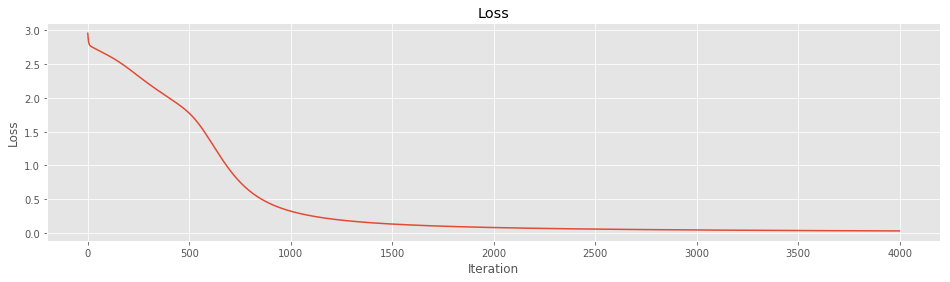

In [16]:
model.show_graph_loss()

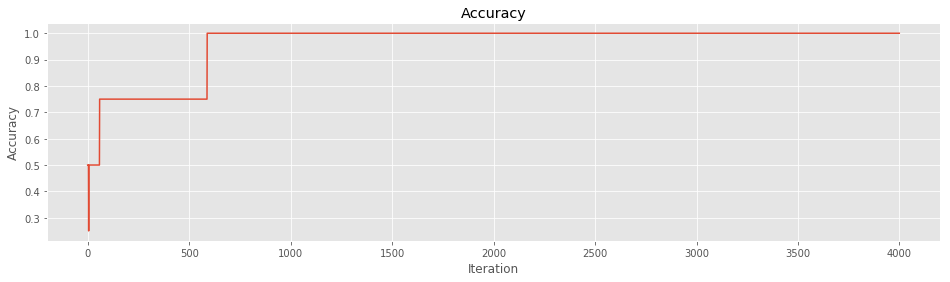

In [17]:
model.show_graph_accuracy()